# XAI Air Quality Analysis - Beijing Dongsi Station

**Course**: WQF7009 Explainable Artificial Intelligence (XAI)  
**University**: University of Malaya  
**Dataset**: Beijing Multi-Site Air Quality - Dongsi Station (Urban Center)  
**Target**: PM2.5 Prediction (Regression)

---

## Table of Contents

1. [Setup & Imports](#1-setup--imports)
2. [Load Data](#2-load-data)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Model Training (XGBoost)](#5-model-training-xgboost)
6. [Model Evaluation](#6-model-evaluation)
7. [SHAP Explanation (Feature Importance)](#7-shap-explanation-feature-importance)
8. [DiCE Counterfactual Explanation](#8-dice-counterfactual-explanation)
9. [Summary & Conclusions](#9-summary--conclusions)

---
## 1. Setup & Imports

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# XAI Methods
import shap
import dice_ml

# Utilities
import joblib
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## 2. Load Data

**Dataset**: Beijing Multi-Site Air Quality - Dongsi Station  
**Source**: UCI Machine Learning Repository  
**Rows**: 35,064 hourly observations (March 2013 - February 2017)

In [2]:
# Load Dongsi station data
DATA_PATH = '../beijing-multisite-uci/raw/PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv'

df_raw = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df_raw.shape}")
print(f"Rows: {df_raw.shape[0]:,}")
print(f"Columns: {df_raw.shape[1]}")

Dataset shape: (35064, 18)
Rows: 35,064
Columns: 18


In [3]:
# Display first few rows
df_raw.head(10)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Dongsi
1,2,2013,3,1,1,4.0,4.0,3.0,16.0,300.0,88.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Dongsi
2,3,2013,3,1,2,7.0,7.0,NaN,17.0,300.0,60.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Dongsi
3,4,2013,3,1,3,3.0,3.0,5.0,18.0,NaN,NaN,-1.4,1026.2,-25.5,0.0,N,4.9,Dongsi
4,5,2013,3,1,4,3.0,3.0,7.0,NaN,200.0,84.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Dongsi
5,6,2013,3,1,5,4.0,4.0,9.0,25.0,300.0,78.0,-2.4,1027.5,-21.3,0.0,NW,2.4,Dongsi
6,7,2013,3,1,6,5.0,5.0,10.0,29.0,400.0,67.0,-2.5,1028.2,-20.4,0.0,NW,2.2,Dongsi
7,8,2013,3,1,7,3.0,6.0,12.0,40.0,400.0,52.0,-1.4,1029.5,-20.4,0.0,NNW,3.0,Dongsi
8,9,2013,3,1,8,3.0,6.0,12.0,41.0,500.0,54.0,-0.3,1030.4,-21.2,0.0,NW,4.6,Dongsi
9,10,2013,3,1,9,3.0,6.0,9.0,31.0,400.0,69.0,0.4,1030.5,-23.3,0.0,N,5.5,Dongsi


In [4]:
# Data types and info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34314 non-null  float64
 6   PM10     34511 non-null  float64
 7   SO2      34401 non-null  float64
 8   NO2      33463 non-null  float64
 9   CO       31867 non-null  float64
 10  O3       34400 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34986 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [5]:
# Column descriptions
column_descriptions = {
    'No': 'Row index (to drop)',
    'year': 'Year (to combine into datetime)',
    'month': 'Month (feature)',
    'day': 'Day (to combine into datetime)',
    'hour': 'Hour (feature)',
    'PM2.5': 'TARGET - Fine particulate matter (µg/m³)',
    'PM10': 'Coarse particulate matter (µg/m³)',
    'SO2': 'Sulfur dioxide (µg/m³)',
    'NO2': 'Nitrogen dioxide (µg/m³)',
    'CO': 'Carbon monoxide (µg/m³)',
    'O3': 'Ozone (µg/m³)',
    'TEMP': 'Temperature (°C)',
    'PRES': 'Atmospheric pressure (hPa)',
    'DEWP': 'Dew point temperature (°C)',
    'RAIN': 'Precipitation (mm)',
    'wd': 'Wind direction (16 categories)',
    'WSPM': 'Wind speed (m/s)',
    'station': 'Station name (constant - Dongsi)'
}

for col, desc in column_descriptions.items():
    print(f"{col:10} : {desc}")

No         : Row index (to drop)
year       : Year (to combine into datetime)
month      : Month (feature)
day        : Day (to combine into datetime)
hour       : Hour (feature)
PM2.5      : TARGET - Fine particulate matter (µg/m³)
PM10       : Coarse particulate matter (µg/m³)
SO2        : Sulfur dioxide (µg/m³)
NO2        : Nitrogen dioxide (µg/m³)
CO         : Carbon monoxide (µg/m³)
O3         : Ozone (µg/m³)
TEMP       : Temperature (°C)
PRES       : Atmospheric pressure (hPa)
DEWP       : Dew point temperature (°C)
RAIN       : Precipitation (mm)
wd         : Wind direction (16 categories)
WSPM       : Wind speed (m/s)
station    : Station name (constant - Dongsi)


---
## 3. Exploratory Data Analysis (EDA)

In [6]:
# Basic statistics
df_raw.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,34314.000000,34511.000000,34401.000000,33463.000000,31867.000000,34400.000000,35044.000000,35044.000000,35044.000000,35044.000000,35050.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,86.194297,110.336742,18.531107,53.699443,1330.069131,57.210637,13.671490,1012.547419,2.447535,0.064020,1.860785
std,10122.249256,1.177213,3.448752,8.800218,6.922285,86.575127,98.219860,22.905655,33.959230,1191.305887,58.033275,11.458418,10.266059,13.810696,0.786282,1.280368
min,1.000000,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.285600,2.000000,100.000000,0.642600,-16.800000,987.100000,-35.300000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,22.000000,38.000000,4.000000,27.000000,600.000000,12.000000,3.100000,1004.000000,-8.800000,0.000000,1.000000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,61.000000,86.000000,10.000000,47.000000,1000.000000,44.125200,14.600000,1012.200000,3.000000,0.000000,1.500000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,119.000000,151.000000,24.000000,73.000000,1700.000000,81.000000,23.500000,1020.900000,15.000000,0.000000,2.400000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,737.000000,955.000000,300.000000,258.000000,10000.000000,1071.000000,41.100000,1042.000000,28.800000,46.400000,10.500000


In [7]:
# Missing values
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

,Missing Count,Missing %
CO,3197,9.12
NO2,1601,4.57
PM2.5,750,2.14
O3,664,1.89
SO2,663,1.89
PM10,553,1.58
wd,78,0.22
TEMP,20,0.06
PRES,20,0.06
DEWP,20,0.06


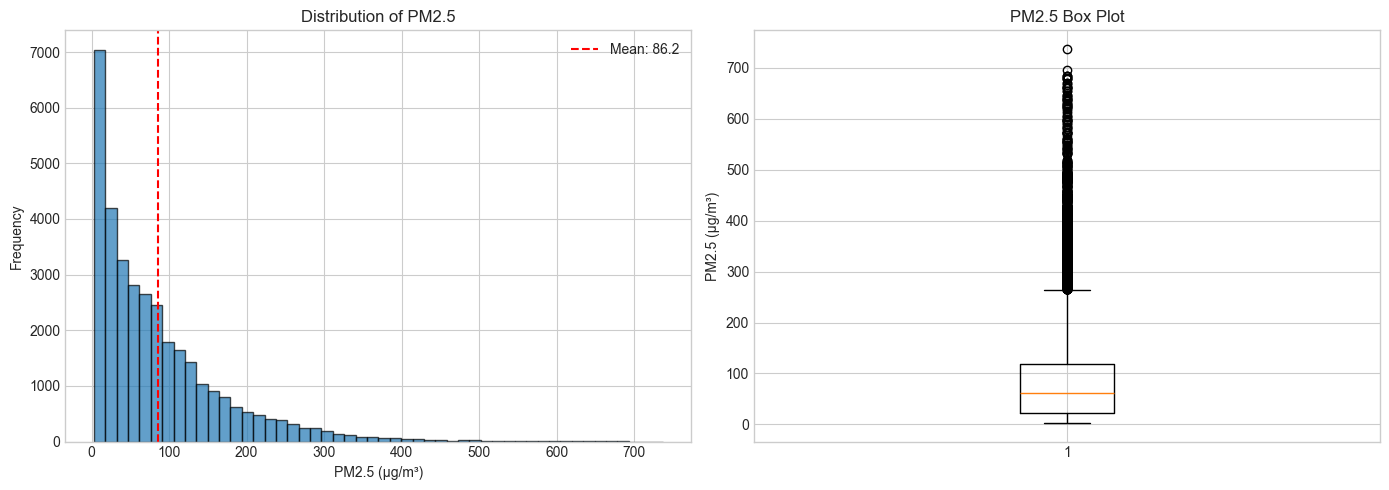

PM2.5 Statistics:
  Mean: 86.19 µg/m³
  Median: 61.00 µg/m³
  Std: 86.58 µg/m³
  Min: 3.00 µg/m³
  Max: 737.00 µg/m³


In [8]:
# Target variable distribution (PM2.5)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_raw['PM2.5'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('PM2.5 (µg/m³)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of PM2.5')
axes[0].axvline(df_raw['PM2.5'].mean(), color='red', linestyle='--', label=f"Mean: {df_raw['PM2.5'].mean():.1f}")
axes[0].legend()

# Box plot
axes[1].boxplot(df_raw['PM2.5'].dropna())
axes[1].set_ylabel('PM2.5 (µg/m³)')
axes[1].set_title('PM2.5 Box Plot')

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/pm25_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PM2.5 Statistics:")
print(f"  Mean: {df_raw['PM2.5'].mean():.2f} µg/m³")
print(f"  Median: {df_raw['PM2.5'].median():.2f} µg/m³")
print(f"  Std: {df_raw['PM2.5'].std():.2f} µg/m³")
print(f"  Min: {df_raw['PM2.5'].min():.2f} µg/m³")
print(f"  Max: {df_raw['PM2.5'].max():.2f} µg/m³")

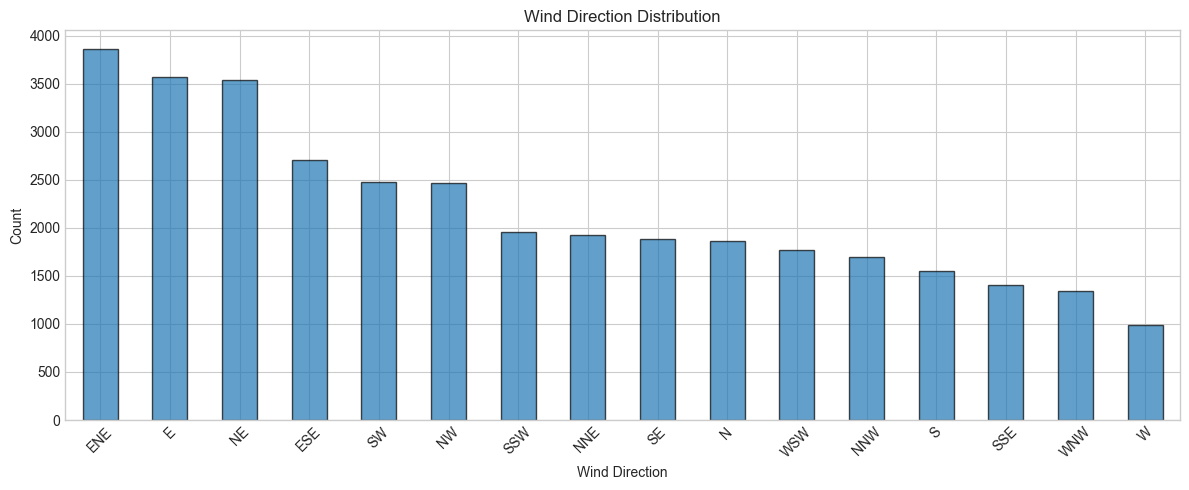


Wind directions: 16 unique values


In [9]:
# Wind direction distribution
wd_counts = df_raw['wd'].value_counts()

plt.figure(figsize=(12, 5))
wd_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Wind Direction')
plt.ylabel('Count')
plt.title('Wind Direction Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/wind_direction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nWind directions: {df_raw['wd'].nunique()} unique values")

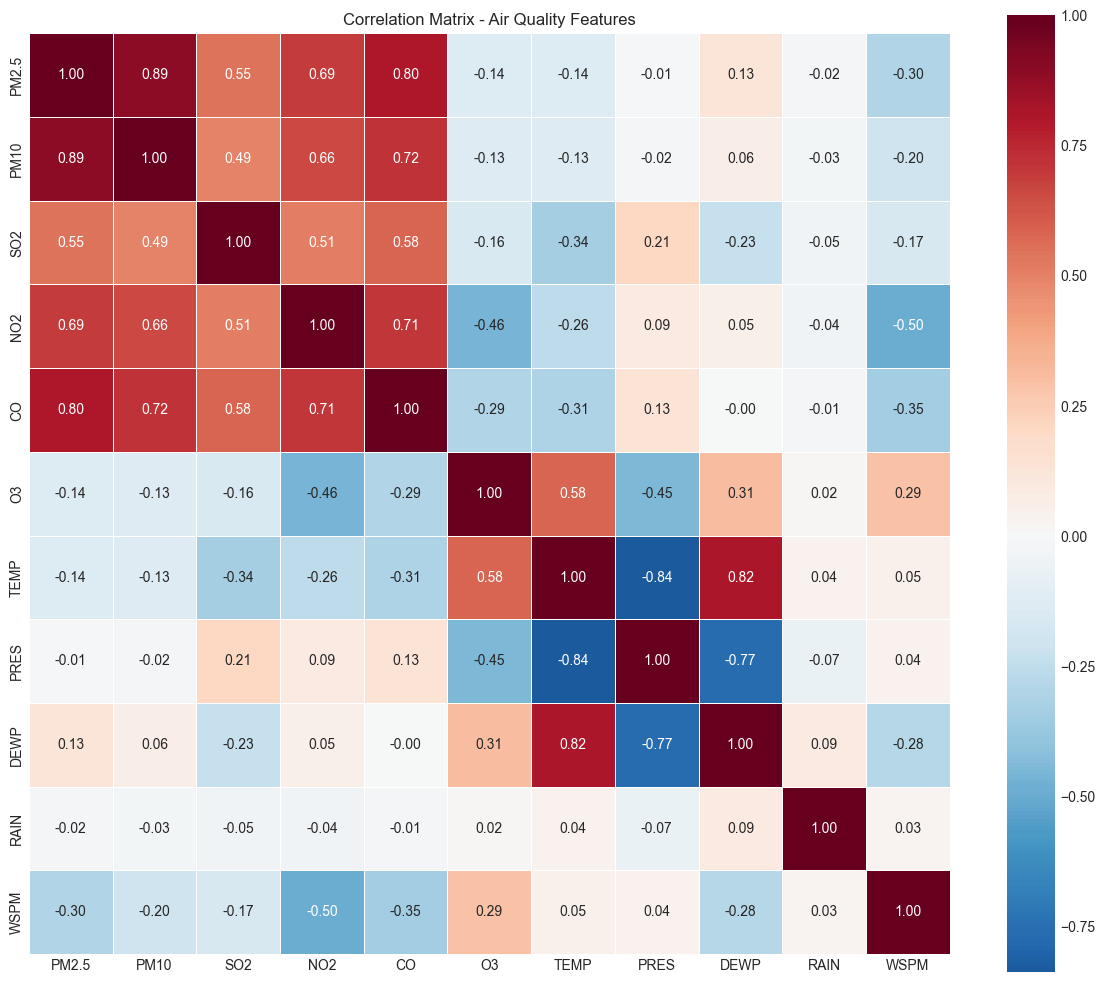


Correlation with PM2.5:
  PM10    : +0.890
  CO      : +0.802
  NO2     : +0.693
  SO2     : +0.547
  WSPM    : -0.302
  TEMP    : -0.139
  O3      : -0.138
  DEWP    : +0.129
  RAIN    : -0.019
  PRES    : -0.006


In [10]:
# Correlation heatmap (numerical features only)
numerical_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
corr_matrix = df_raw[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Air Quality Features')
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Top correlations with PM2.5
pm25_corr = corr_matrix['PM2.5'].drop('PM2.5').sort_values(key=abs, ascending=False)
print("\nCorrelation with PM2.5:")
for feat, corr in pm25_corr.items():
    print(f"  {feat:8}: {corr:+.3f}")

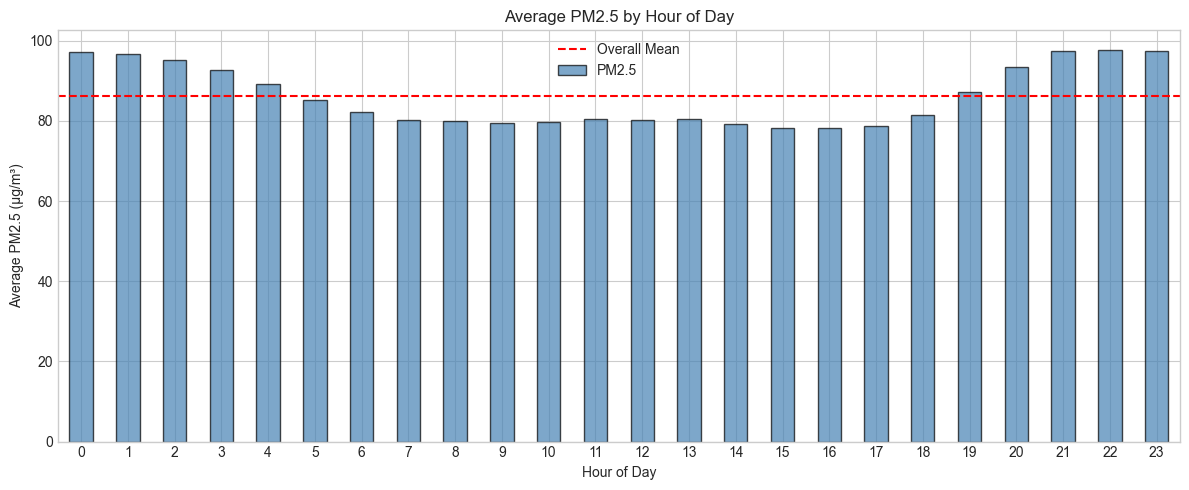

In [11]:
# PM2.5 by hour of day
hourly_pm25 = df_raw.groupby('hour')['PM2.5'].mean()

plt.figure(figsize=(12, 5))
hourly_pm25.plot(kind='bar', edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.title('Average PM2.5 by Hour of Day')
plt.xticks(rotation=0)
plt.axhline(hourly_pm25.mean(), color='red', linestyle='--', label='Overall Mean')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/pm25_by_hour.png', dpi=150, bbox_inches='tight')
plt.show()

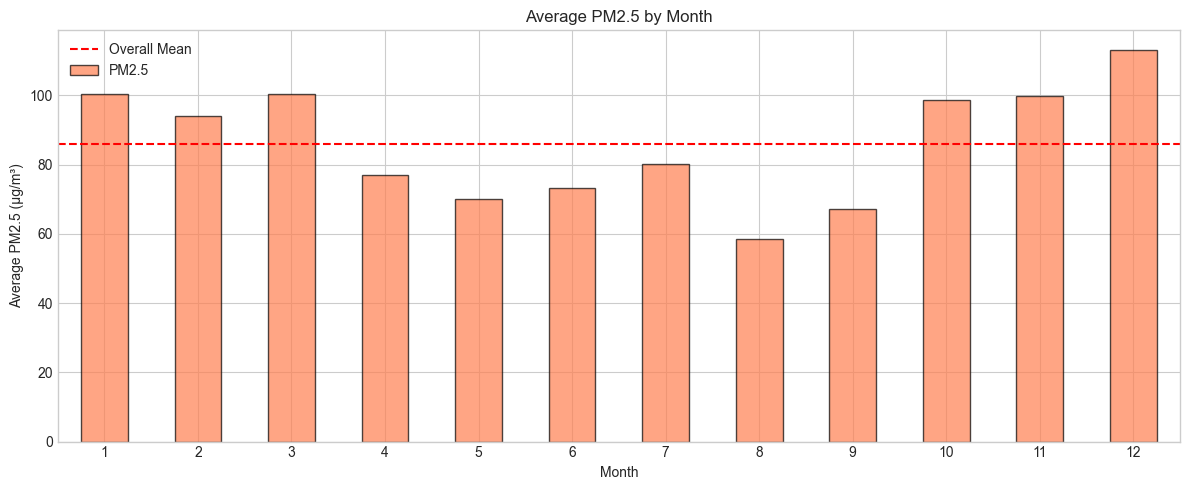


Seasonal Pattern:
  Winter (Dec-Feb) avg: 102.8 µg/m³
  Summer (Jun-Aug) avg: 70.6 µg/m³


In [12]:
# PM2.5 by month
monthly_pm25 = df_raw.groupby('month')['PM2.5'].mean()

plt.figure(figsize=(12, 5))
monthly_pm25.plot(kind='bar', edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.title('Average PM2.5 by Month')
plt.xticks(rotation=0)
plt.axhline(monthly_pm25.mean(), color='red', linestyle='--', label='Overall Mean')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/pm25_by_month.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSeasonal Pattern:")
print(f"  Winter (Dec-Feb) avg: {df_raw[df_raw['month'].isin([12, 1, 2])]['PM2.5'].mean():.1f} µg/m³")
print(f"  Summer (Jun-Aug) avg: {df_raw[df_raw['month'].isin([6, 7, 8])]['PM2.5'].mean():.1f} µg/m³")

---
## 4. Data Preprocessing

In [13]:
# Create a copy for preprocessing
df = df_raw.copy()

print(f"Original shape: {df.shape}")

Original shape: (35064, 18)


In [14]:
# Step 1: Create datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")

Date range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00


In [15]:
# Step 2: Drop unnecessary columns
columns_to_drop = ['No', 'year', 'day', 'station', 'datetime']
df = df.drop(columns=columns_to_drop)

print(f"Columns after dropping: {list(df.columns)}")
print(f"Shape: {df.shape}")

Columns after dropping: ['month', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']
Shape: (35064, 14)


In [16]:
# Step 3: Handle missing values
print("Missing values before:")
print(df.isnull().sum())

# Drop rows with missing target (PM2.5)
df = df.dropna(subset=['PM2.5'])

# For other features, fill with median (numerical) or mode (categorical)
numerical_features = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())

# Fill missing wind direction with mode
df['wd'] = df['wd'].fillna(df['wd'].mode()[0])

print(f"\nMissing values after: {df.isnull().sum().sum()}")
print(f"Final shape: {df.shape}")

Missing values before:
month       0
hour        0
PM2.5     750
PM10      553
SO2       663
NO2      1601
CO       3197
O3        664
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         78
WSPM       14
dtype: int64

Missing values after: 0
Final shape: (34314, 14)


In [17]:
# Step 4: Define features and target
TARGET = 'PM2.5'

FEATURES = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'hour', 'month']

print(f"Target: {TARGET}")
print(f"Features ({len(FEATURES)}): {FEATURES}")

Target: PM2.5
Features (13): ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'hour', 'month']


In [18]:
# Step 5: Prepare X and y
X = df[FEATURES].copy()
y = df[TARGET].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeature types:")
print(X.dtypes)

X shape: (34314, 13)
y shape: (34314,)

Feature types:
PM10     float64
SO2      float64
NO2      float64
CO       float64
O3       float64
TEMP     float64
PRES     float64
DEWP     float64
RAIN     float64
WSPM     float64
wd        object
hour       int64
month      int64
dtype: object


In [19]:
# Step 6: Convert 'wd' to category type for XGBoost
X['wd'] = X['wd'].astype('category')

print(f"Wind direction categories: {X['wd'].cat.categories.tolist()}")

Wind direction categories: ['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']


In [20]:
# Step 7: Train/Validation/Test split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 0.15

print(f"Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Train set: 24,032 samples (70.0%)
Val set:   5,134 samples (15.0%)
Test set:  5,148 samples (15.0%)


In [21]:
# Step 8: Save processed data
train_data = X_train.copy()
train_data[TARGET] = y_train
train_data.to_csv('../data/processed/train.csv', index=False)

val_data = X_val.copy()
val_data[TARGET] = y_val
val_data.to_csv('../data/processed/val.csv', index=False)

test_data = X_test.copy()
test_data[TARGET] = y_test
test_data.to_csv('../data/processed/test.csv', index=False)

print("Processed data saved to data/processed/")

Processed data saved to data/processed/


In [22]:
# Summary of preprocessing
print("="*60)
print("PREPROCESSING SUMMARY")
print("="*60)
print(f"Original rows: {df_raw.shape[0]:,}")
print(f"Final rows: {len(X):,}")
print(f"Rows removed: {df_raw.shape[0] - len(X):,}")
print(f"\nFeatures: {len(FEATURES)}")
print(f"  - Pollutants (5): PM10, SO2, NO2, CO, O3")
print(f"  - Weather (5): TEMP, PRES, DEWP, RAIN, WSPM")
print(f"  - Wind (1): wd (categorical)")
print(f"  - Temporal (2): hour, month")
print(f"\nTarget: {TARGET}")
print("="*60)

PREPROCESSING SUMMARY
Original rows: 35,064
Final rows: 34,314
Rows removed: 750

Features: 13
  - Pollutants (5): PM10, SO2, NO2, CO, O3
  - Weather (5): TEMP, PRES, DEWP, RAIN, WSPM
  - Wind (1): wd (categorical)
  - Temporal (2): hour, month

Target: PM2.5


---
## 5. Model Training (XGBoost)

**Model**: XGBoost Regressor (black-box model)  
**Why XGBoost**:
- Handles mixed features (categorical + numerical)
- Strong baseline performance for tabular data
- Black-box nature suitable for XAI demonstration
- SHAP has optimized TreeExplainer for tree-based models

In [23]:
# Initialize XGBoost model
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    enable_categorical=True,  # Enable native categorical support
    tree_method='hist'  # Required for categorical support
)

print("XGBoost model initialized with parameters:")
print(f"  n_estimators: 200")
print(f"  max_depth: 6")
print(f"  learning_rate: 0.1")
print(f"  enable_categorical: True")

XGBoost model initialized with parameters:
  n_estimators: 200
  max_depth: 6
  learning_rate: 0.1
  enable_categorical: True


In [24]:
# Train the model
print("Training XGBoost model...")

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

print("\nTraining complete!")

Training XGBoost model...
[0]	validation_0-rmse:79.22994	validation_1-rmse:78.85452
[50]	validation_0-rmse:19.94466	validation_1-rmse:23.06967
[100]	validation_0-rmse:16.87813	validation_1-rmse:21.42137
[150]	validation_0-rmse:15.23279	validation_1-rmse:20.80702
[199]	validation_0-rmse:13.93719	validation_1-rmse:20.40251

Training complete!


In [25]:
# Save the model
MODEL_PATH = '../models/xgboost_model.pkl'
joblib.dump(model, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ../models/xgboost_model.pkl


---
## 6. Model Evaluation

In [26]:
# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [27]:
# Calculate metrics
def evaluate_model(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = evaluate_model(y_train, y_train_pred, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


Training Performance:
  RMSE: 13.9372
  MAE:  9.6546
  R²:   0.9743

Validation Performance:
  RMSE: 20.4025
  MAE:  13.0003
  R²:   0.9442

Test Performance:
  RMSE: 18.9867
  MAE:  12.4257
  R²:   0.9501


In [28]:
# Metrics summary table
metrics_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE']],
    'MAE': [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE']],
    'R²': [train_metrics['R2'], val_metrics['R2'], test_metrics['R2']]
})

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)


MODEL PERFORMANCE SUMMARY
   Dataset      RMSE       MAE       R²
     Train 13.937192  9.654644 0.974299
Validation 20.402514 13.000344 0.944192
      Test 18.986686 12.425739 0.950144


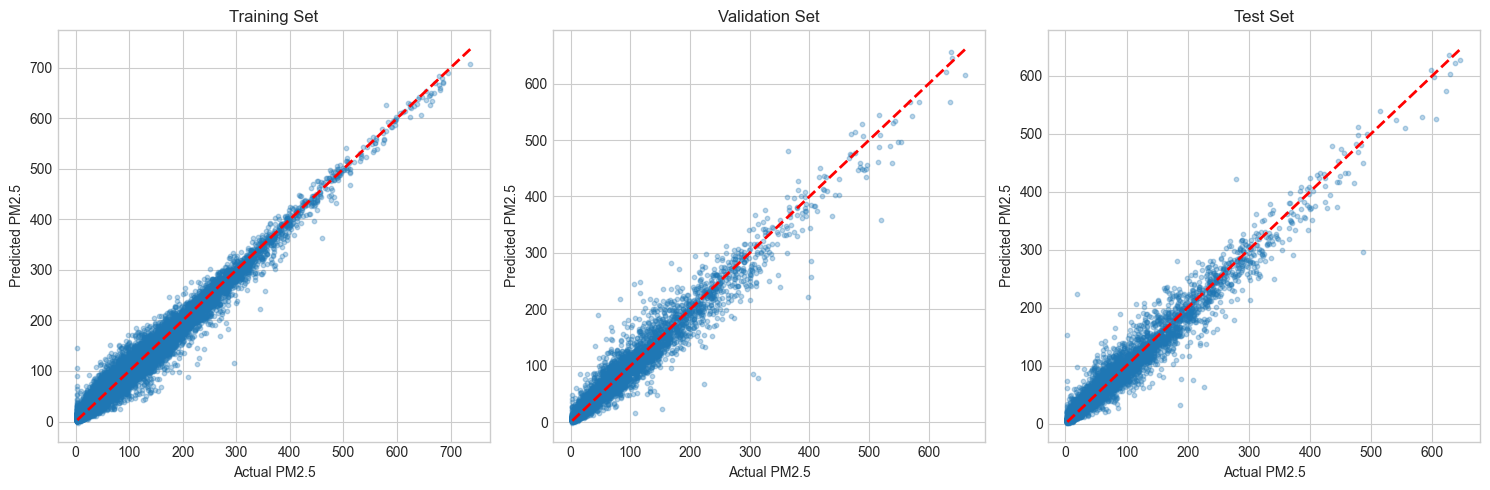

In [29]:
# Actual vs Predicted plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [
    (y_train, y_train_pred, 'Training'),
    (y_val, y_val_pred, 'Validation'),
    (y_test, y_test_pred, 'Test')
]

for ax, (y_true, y_pred, name) in zip(axes, datasets):
    ax.scatter(y_true, y_pred, alpha=0.3, s=10)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax.set_xlabel('Actual PM2.5')
    ax.set_ylabel('Predicted PM2.5')
    ax.set_title(f'{name} Set')
    
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

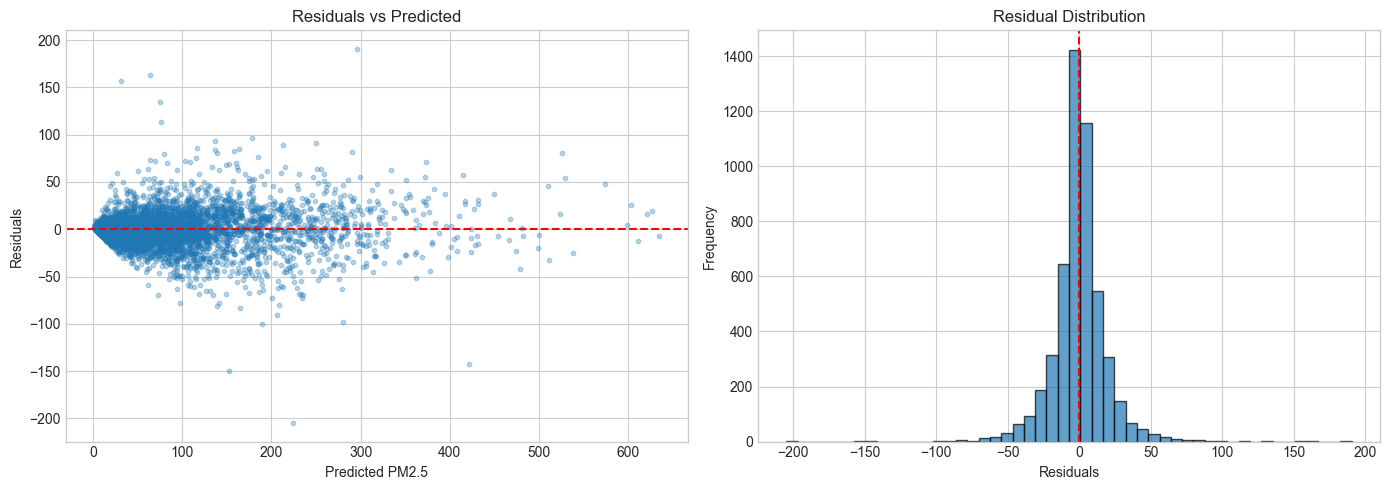

In [30]:
# Residual plot
residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
axes[0].scatter(y_test_pred, residuals, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted PM2.5')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

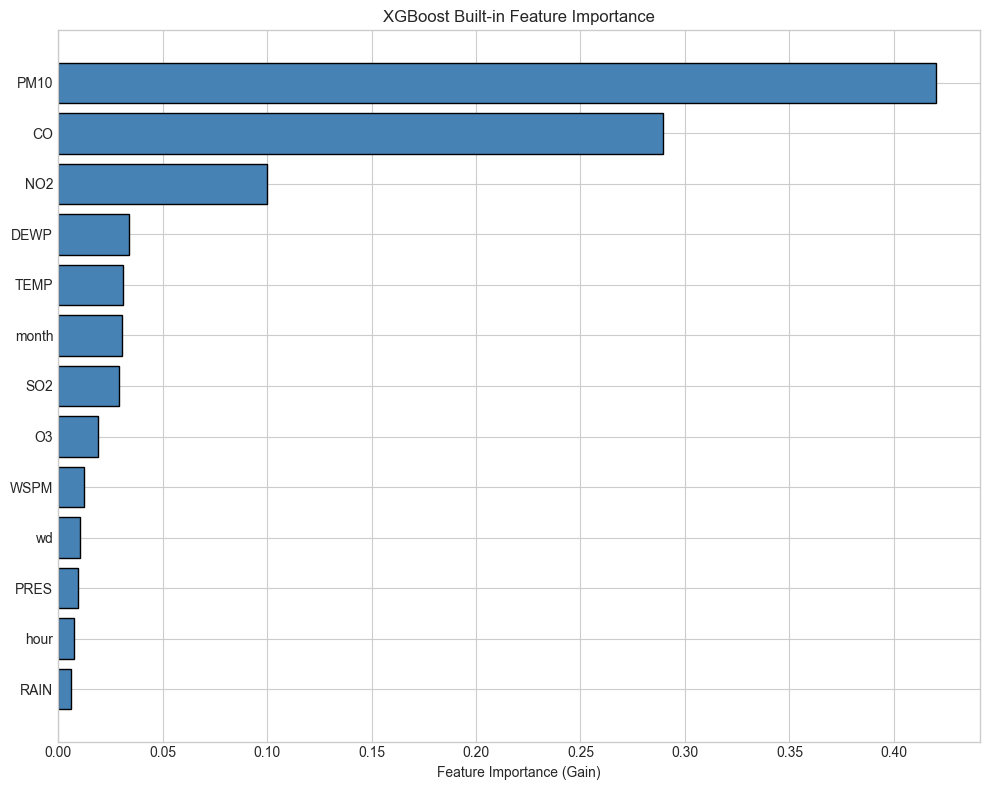

In [31]:
# Feature importance from XGBoost (built-in)
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': importance
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue', edgecolor='black')
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Built-in Feature Importance')
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/xgboost_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. SHAP Explanation (Feature Importance)

**Method**: SHAP (SHapley Additive exPlanations)  
**Type**: Model-agnostic, Post-hoc, Global + Local  
**Question answered**: "Which features contribute to the prediction and how?"

In [32]:
# Initialize SHAP explainer
print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model)

# Calculate SHAP values (use a subset for faster computation)
print("Calculating SHAP values (this may take a moment)...")
X_sample = X_test.sample(n=min(1000, len(X_test)), random_state=42)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values calculated for {len(X_sample)} samples")

Initializing SHAP TreeExplainer...
Calculating SHAP values (this may take a moment)...
SHAP values calculated for 1000 samples


### 7.1 SHAP Summary Plot (Global Feature Importance)

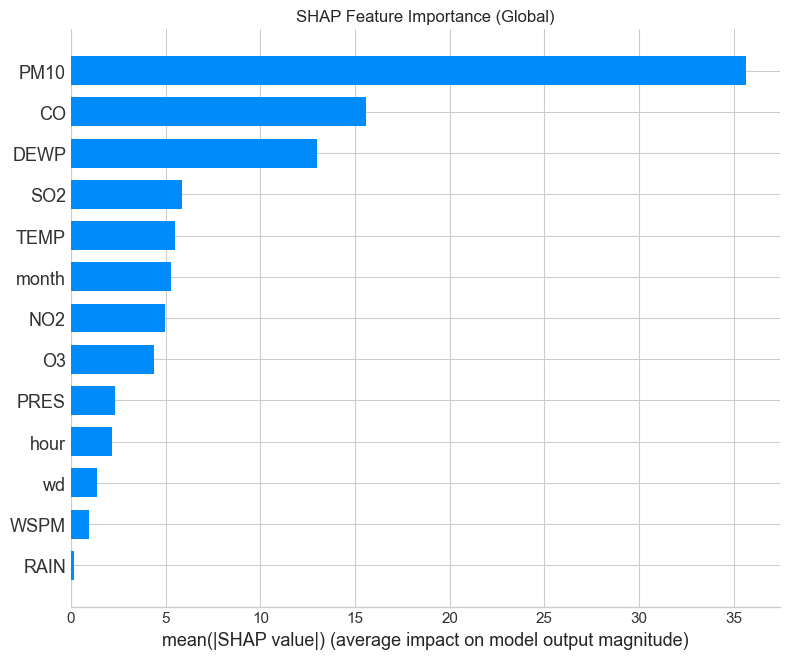

In [33]:
# Summary plot - bar
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Global)')
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_summary_bar.png', dpi=150, bbox_inches='tight')
plt.show()

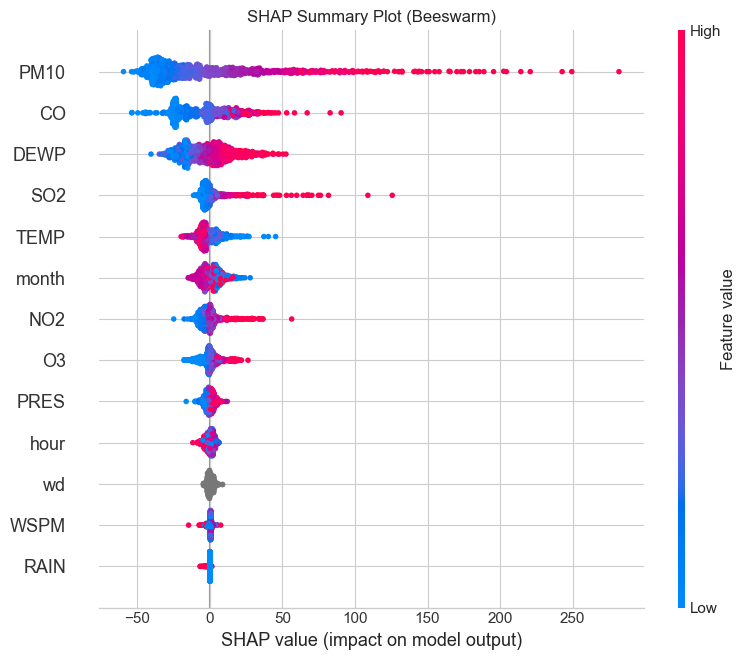

In [34]:
# Summary plot - beeswarm
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot (Beeswarm)')
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_summary_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.2 SHAP Force Plot (Local Explanation)

In [35]:
# Initialize JavaScript for SHAP force plots
shap.initjs()

# Force plot for a single prediction (high PM2.5)
# Find an index with high PM2.5
high_pm25_idx = y_test[y_test > y_test.quantile(0.9)].index[0]
sample_idx = X_test.index.get_loc(high_pm25_idx) if high_pm25_idx in X_test.index else 0

print(f"Explaining prediction for sample with high PM2.5")
print(f"Actual PM2.5: {y_test.iloc[sample_idx]:.2f}")
print(f"Predicted PM2.5: {model.predict(X_test.iloc[[sample_idx]])[0]:.2f}")

Explaining prediction for sample with high PM2.5
Actual PM2.5: 226.00
Predicted PM2.5: 162.88


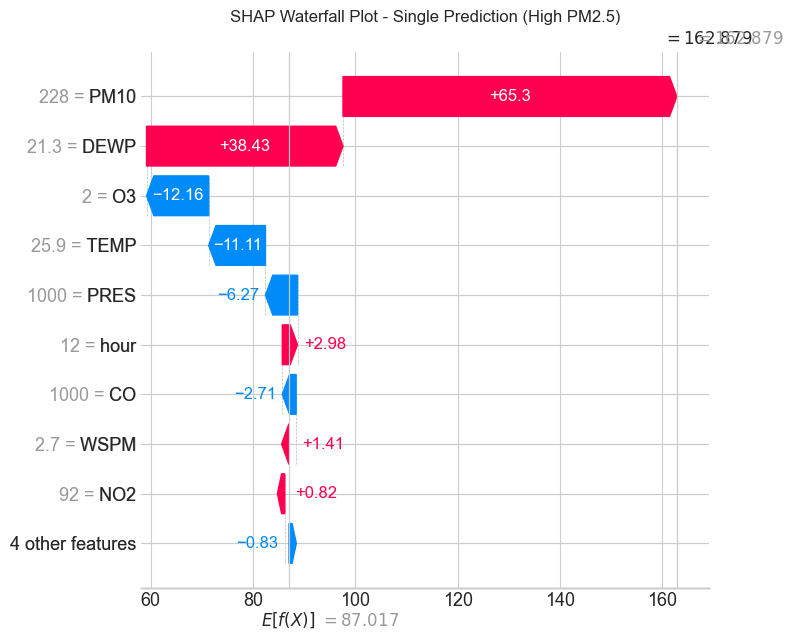

In [36]:
# Waterfall plot for single prediction
shap_explanation = shap.Explanation(
    values=explainer.shap_values(X_test.iloc[[sample_idx]])[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx].values,
    feature_names=FEATURES
)

plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_explanation, show=False)
plt.title('SHAP Waterfall Plot - Single Prediction (High PM2.5)')
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.2.2 SHAP Temporal Comparison: Evening Peak (9 PM) vs Afternoon Low (2 PM)

Based on scientific literature (Zhao et al., 2009, *Atmospheric Environment*), Beijing PM2.5 follows a **bimodal diurnal pattern**:
- **Evening (7-11 PM)**: Highest pollution due to accumulated emissions + boundary layer collapse
- **Afternoon (12-3 PM)**: Lowest pollution due to atmospheric mixing and dispersion

This comparison shows the contrast between pollution PEAK and LOW periods.

In [37]:
# AGGREGATE SHAP Comparison: Evening Peak (9 PM) vs Afternoon Low (2 PM)
# Based on scientific diurnal pattern of PM2.5 in Beijing

print('Calculating aggregate SHAP values for Evening vs Afternoon...')
print('='*60)

# Get all samples for each time period
evening_mask = X_test['hour'] == 21  # 9 PM - highest pollution
afternoon_mask = X_test['hour'] == 14  # 2 PM - low pollution (good dispersion)

X_evening = X_test[evening_mask]
X_afternoon = X_test[afternoon_mask]

print(f'Evening (9 PM) samples: {len(X_evening)}')
print(f'Afternoon (2 PM) samples: {len(X_afternoon)}')
print(f'\nAverage PM2.5 at 9 PM: {y_test[evening_mask].mean():.1f} µg/m³')
print(f'Average PM2.5 at 2 PM: {y_test[afternoon_mask].mean():.1f} µg/m³')

# Calculate SHAP values for all samples in each group
shap_values_evening = explainer.shap_values(X_evening)
shap_values_afternoon = explainer.shap_values(X_afternoon)

# Calculate mean absolute SHAP per feature
mean_abs_shap_evening = np.abs(shap_values_evening).mean(axis=0)
mean_abs_shap_afternoon = np.abs(shap_values_afternoon).mean(axis=0)

# Create comparison DataFrame
temporal_comparison_df = pd.DataFrame({
    'Feature': FEATURES,
    'Evening (9 PM)': mean_abs_shap_evening,
    'Afternoon (2 PM)': mean_abs_shap_afternoon
})
temporal_comparison_df['Difference'] = temporal_comparison_df['Evening (9 PM)'] - temporal_comparison_df['Afternoon (2 PM)']
temporal_comparison_df = temporal_comparison_df.sort_values('Evening (9 PM)', ascending=False)

print('\nMean Absolute SHAP Values by Time Period:')
print(temporal_comparison_df.to_string(index=False))

Calculating aggregate SHAP values for Evening vs Afternoon...
Evening (9 PM) samples: 230
Afternoon (2 PM) samples: 232

Average PM2.5 at 9 PM: 103.6 µg/m³
Average PM2.5 at 2 PM: 76.3 µg/m³

Mean Absolute SHAP Values by Time Period:
Feature  Evening (9 PM)  Afternoon (2 PM)  Difference
   PM10       41.042469         34.891506    6.150963
     CO       15.781090         16.838182   -1.057093
   DEWP       14.325084         11.554822    2.770262
    SO2        6.908566          4.650883    2.257682
    NO2        6.169367          6.238740   -0.069373
   TEMP        5.942624          4.740721    1.201903
  month        5.592975          4.835093    0.757882
     O3        4.033586          5.460587   -1.427001
   hour        3.564867          2.983187    0.581680
   PRES        2.246767          2.350137   -0.103369
     wd        1.523348          1.563024   -0.039676
   WSPM        1.189795          1.060138    0.129656
   RAIN        0.158456          0.155813    0.002644


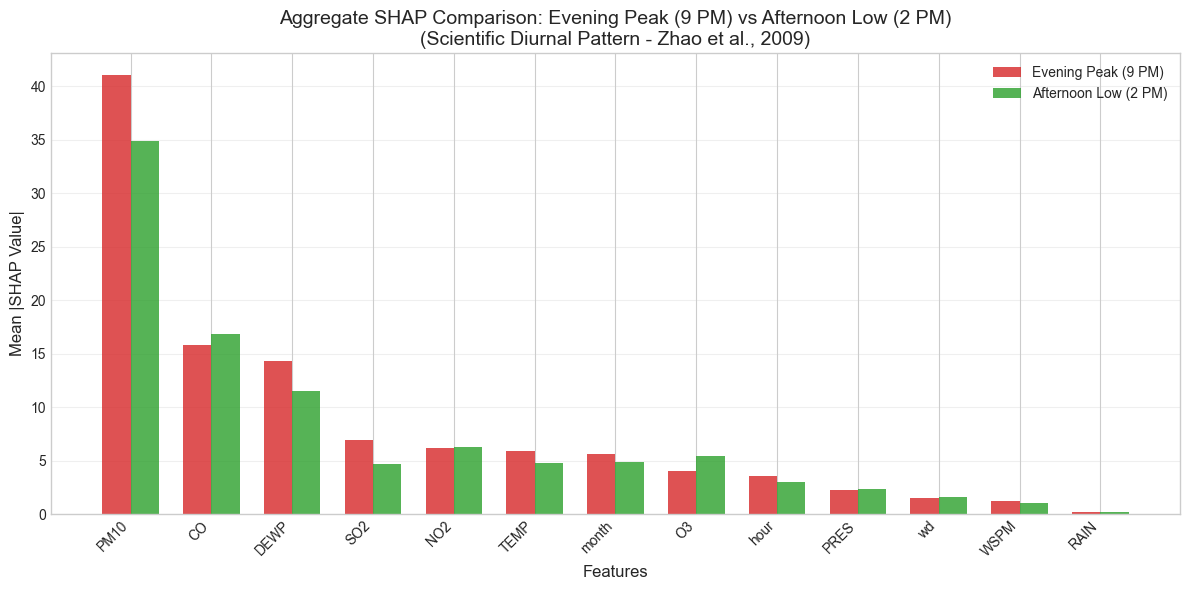


KEY INSIGHTS: Evening Peak (9 PM) vs Afternoon Low (2 PM)

Features MORE important during Evening Peak (9 PM):
  - PM10: +6.15 higher SHAP
  - DEWP: +2.77 higher SHAP
  - SO2: +2.26 higher SHAP

Features MORE important during Afternoon Low (2 PM):
  - O3: +1.43 higher SHAP
  - CO: +1.06 higher SHAP
  - PRES: +0.10 higher SHAP


In [38]:
# Visualize Aggregate SHAP Comparison: Evening vs Afternoon
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(FEATURES))
width = 0.35

# Sort by evening importance
sorted_idx = np.argsort(mean_abs_shap_evening)[::-1]
sorted_features = [FEATURES[i] for i in sorted_idx]
sorted_evening = mean_abs_shap_evening[sorted_idx]
sorted_afternoon = mean_abs_shap_afternoon[sorted_idx]

bars1 = ax.bar(x - width/2, sorted_evening, width, label='Evening Peak (9 PM)', color='#d62728', alpha=0.8)
bars2 = ax.bar(x + width/2, sorted_afternoon, width, label='Afternoon Low (2 PM)', color='#2ca02c', alpha=0.8)

ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Aggregate SHAP Comparison: Evening Peak (9 PM) vs Afternoon Low (2 PM)\n(Scientific Diurnal Pattern - Zhao et al., 2009)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(sorted_features, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_evening_vs_afternoon_aggregate.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('KEY INSIGHTS: Evening Peak (9 PM) vs Afternoon Low (2 PM)')
print('='*60)

# Find features with biggest differences
diff_temporal = mean_abs_shap_evening - mean_abs_shap_afternoon
evening_dominant = [(FEATURES[i], diff_temporal[i]) for i in np.argsort(diff_temporal)[::-1][:3]]
afternoon_dominant = [(FEATURES[i], -diff_temporal[i]) for i in np.argsort(diff_temporal)[:3]]

print('\nFeatures MORE important during Evening Peak (9 PM):')
for feat, d in evening_dominant:
    if d > 0:
        print(f'  - {feat}: +{d:.2f} higher SHAP')

print('\nFeatures MORE important during Afternoon Low (2 PM):')
for feat, d in afternoon_dominant:
    if d > 0:
        print(f'  - {feat}: +{d:.2f} higher SHAP')
print('='*60)

In [39]:
# SHAP Waterfall: Contrasting Samples (High vs Low Pollution)
# Select samples that clearly show the difference between peak and low hours

# Load raw data to get date information
raw_df = pd.read_csv('../data/raw/PRSA_Data_Dongsi_20130301-20170228.csv')

print('Selecting contrasting samples for meaningful comparison...')
print('='*60)

# Overall mean for reference
overall_pm25_mean = y_test.mean()
print(f'Overall PM2.5 Mean: {overall_pm25_mean:.1f} µg/m³')

# Evening (9 PM) - select HIGH pollution sample (above 75th percentile for that hour)
evening_pm25 = y_test[evening_mask]
evening_p75 = evening_pm25.quantile(0.75)
evening_high_samples = evening_pm25[evening_pm25 >= evening_p75]
evening_selected_idx = evening_high_samples.index[0]  # First high-pollution sample
evening_sample_loc = X_test.index.get_loc(evening_selected_idx)
evening_sample = X_test.loc[evening_selected_idx]

# Find date from raw data
evening_match = raw_df[
    (raw_df['hour'] == evening_sample['hour']) & 
    (raw_df['month'] == evening_sample['month']) & 
    (raw_df['PM2.5'] == y_test.loc[evening_selected_idx]) &
    (raw_df['PM10'] == evening_sample['PM10'])
]
if len(evening_match) > 0:
    evening_date = f"{evening_match.iloc[0]['year']}-{evening_match.iloc[0]['month']:02d}-{evening_match.iloc[0]['day']:02d}"
else:
    evening_date = f"Month {int(evening_sample['month'])}"

print(f'\nEvening Peak (9 PM) - HIGH pollution sample:')
print(f'  Date: {evening_date}')
print(f'  PM2.5: {y_test.loc[evening_selected_idx]:.1f} µg/m³ (above 75th percentile)')
print(f'  PM10: {evening_sample["PM10"]:.1f}, CO: {evening_sample["CO"]:.1f}')

# Afternoon (2 PM) - select LOW pollution sample (below 25th percentile for that hour)
afternoon_pm25 = y_test[afternoon_mask]
afternoon_p25 = afternoon_pm25.quantile(0.25)
afternoon_low_samples = afternoon_pm25[afternoon_pm25 <= afternoon_p25]
afternoon_selected_idx = afternoon_low_samples.index[0]  # First low-pollution sample
afternoon_sample_loc = X_test.index.get_loc(afternoon_selected_idx)
afternoon_sample = X_test.loc[afternoon_selected_idx]

# Find date from raw data
afternoon_match = raw_df[
    (raw_df['hour'] == afternoon_sample['hour']) & 
    (raw_df['month'] == afternoon_sample['month']) & 
    (raw_df['PM2.5'] == y_test.loc[afternoon_selected_idx]) &
    (raw_df['PM10'] == afternoon_sample['PM10'])
]
if len(afternoon_match) > 0:
    afternoon_date = f"{afternoon_match.iloc[0]['year']}-{afternoon_match.iloc[0]['month']:02d}-{afternoon_match.iloc[0]['day']:02d}"
else:
    afternoon_date = f"Month {int(afternoon_sample['month'])}"

print(f'\nAfternoon Low (2 PM) - LOW pollution sample:')
print(f'  Date: {afternoon_date}')
print(f'  PM2.5: {y_test.loc[afternoon_selected_idx]:.1f} µg/m³ (below 25th percentile)')
print(f'  PM10: {afternoon_sample["PM10"]:.1f}, CO: {afternoon_sample["CO"]:.1f}')
print('='*60)

Selecting contrasting samples for meaningful comparison...
Overall PM2.5 Mean: 84.1 µg/m³

Evening Peak (9 PM) - HIGH pollution sample:
  Date: 2015-04-10
  PM2.5: 148.0 µg/m³ (above 75th percentile)
  PM10: 199.0, CO: 1800.0

Afternoon Low (2 PM) - LOW pollution sample:
  Date: 2013-03-24
  PM2.5: 5.0 µg/m³ (below 25th percentile)
  PM10: 7.0, CO: 200.0


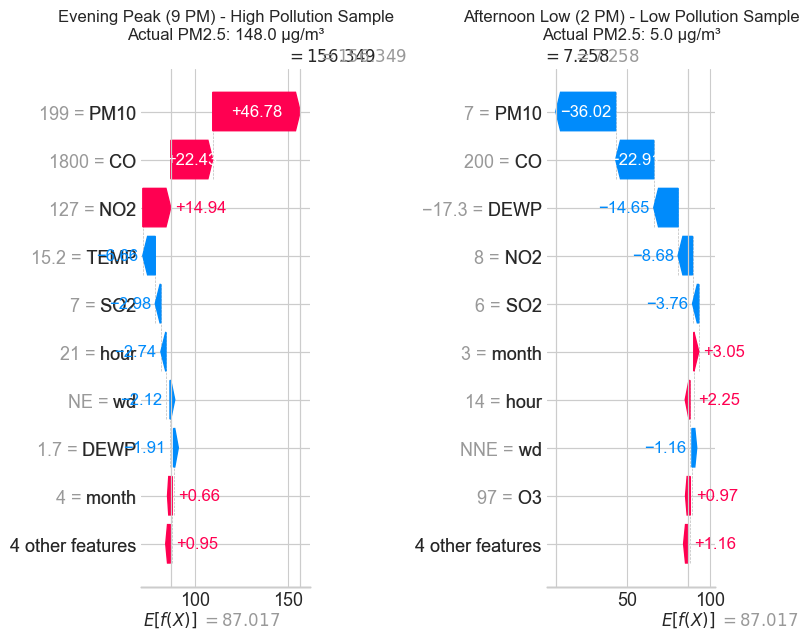


WATERFALL INTERPRETATION

Evening Peak (9 PM) - HIGH pollution sample:
  RED bars (positive SHAP) = features pushing prediction UP
  High PM10, CO values → positive contribution to pollution

Afternoon Low (2 PM) - LOW pollution sample:
  BLUE bars (negative SHAP) = features pushing prediction DOWN
  Low PM10, CO values → negative contribution (below baseline)


In [40]:
# Create SHAP Waterfall Plots for Contrasting Samples
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Evening (9 PM) - High Pollution Sample
shap_evening_sample = shap.Explanation(
    values=explainer.shap_values(X_test.iloc[[evening_sample_loc]])[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[evening_sample_loc].values,
    feature_names=FEATURES
)

# Afternoon (2 PM) - Low Pollution Sample
shap_afternoon_sample = shap.Explanation(
    values=explainer.shap_values(X_test.iloc[[afternoon_sample_loc]])[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[afternoon_sample_loc].values,
    feature_names=FEATURES
)

# Plot Evening (High Pollution)
plt.subplot(1, 2, 1)
shap.waterfall_plot(shap_evening_sample, show=False)
plt.title(f'Evening Peak (9 PM) - High Pollution Sample\nActual PM2.5: {y_test.iloc[evening_sample_loc]:.1f} µg/m³')

# Plot Afternoon (Low Pollution)
plt.subplot(1, 2, 2)
shap.waterfall_plot(shap_afternoon_sample, show=False)
plt.title(f'Afternoon Low (2 PM) - Low Pollution Sample\nActual PM2.5: {y_test.iloc[afternoon_sample_loc]:.1f} µg/m³')

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_evening_vs_afternoon_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('WATERFALL INTERPRETATION')
print('='*60)
print('\nEvening Peak (9 PM) - HIGH pollution sample:')
print('  RED bars (positive SHAP) = features pushing prediction UP')
print('  High PM10, CO values → positive contribution to pollution')

print('\nAfternoon Low (2 PM) - LOW pollution sample:')
print('  BLUE bars (negative SHAP) = features pushing prediction DOWN')
print('  Low PM10, CO values → negative contribution (below baseline)')
print('='*60)

### 7.2.3 SHAP Comparison: Winter vs Summer

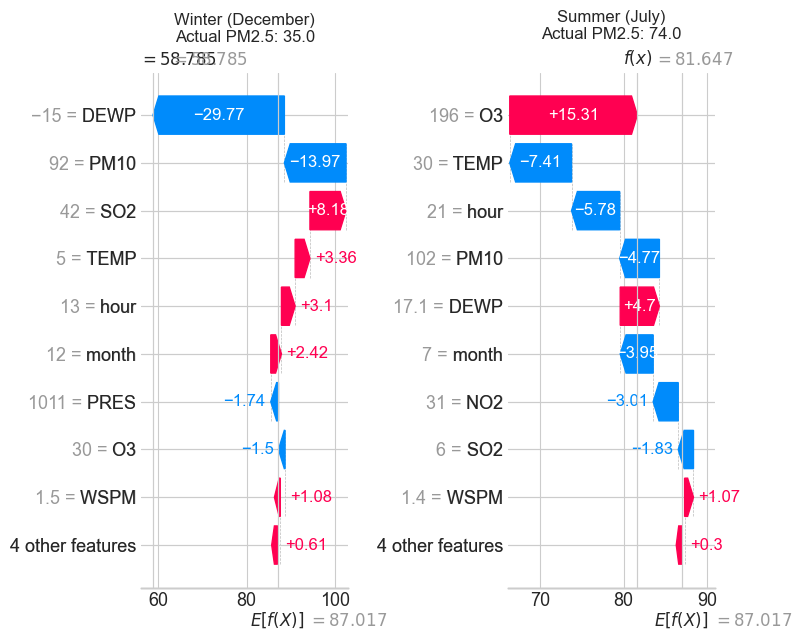


COMPARISON: Winter (December) vs Summer (July)
Winter PM2.5: 35.0 µg/m³
Summer PM2.5: 74.0 µg/m³


In [41]:
# Compare: Winter (December) vs Summer (July)

# Winter sample (month = 12)
winter_mask = (X_test['month'] == 12)
winter_sample = X_test[winter_mask].sample(1, random_state=42)
winter_idx = X_test.index.get_loc(winter_sample.index[0])

# Summer sample (month = 7)
summer_mask = (X_test['month'] == 7)
summer_sample = X_test[summer_mask].sample(1, random_state=42)
summer_idx = X_test.index.get_loc(summer_sample.index[0])

# Create waterfall plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Winter
shap_winter = shap.Explanation(
    values=explainer.shap_values(X_test.iloc[[winter_idx]])[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[winter_idx].values,
    feature_names=FEATURES
)

# Summer
shap_summer = shap.Explanation(
    values=explainer.shap_values(X_test.iloc[[summer_idx]])[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[summer_idx].values,
    feature_names=FEATURES
)

plt.subplot(1, 2, 1)
shap.waterfall_plot(shap_winter, show=False)
plt.title(f'Winter (December)\nActual PM2.5: {y_test.iloc[winter_idx]:.1f}')

plt.subplot(1, 2, 2)
shap.waterfall_plot(shap_summer, show=False)
plt.title(f'Summer (July)\nActual PM2.5: {y_test.iloc[summer_idx]:.1f}')

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_winter_vs_summer.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('COMPARISON: Winter (December) vs Summer (July)')
print('='*60)
print(f'Winter PM2.5: {y_test.iloc[winter_idx]:.1f} µg/m³')
print(f'Summer PM2.5: {y_test.iloc[summer_idx]:.1f} µg/m³')
print('='*60)

### 7.2.4 SHAP Comparison: High vs Low Pollution

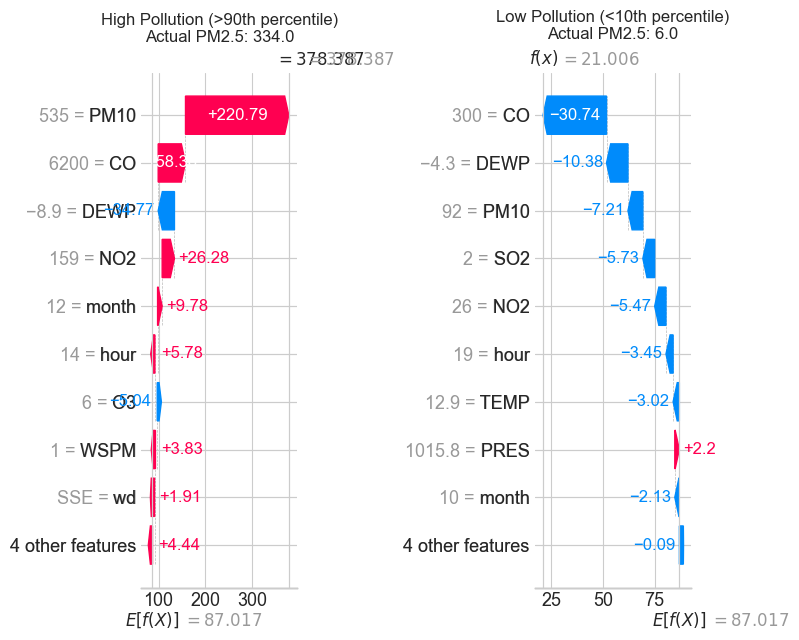


COMPARISON: High Pollution vs Low Pollution
High Pollution PM2.5: 334.0 µg/m³ (Top 10%)
Low Pollution PM2.5: 6.0 µg/m³ (Bottom 10%)


In [42]:
# Compare: High Pollution (>90th percentile) vs Low Pollution (<10th percentile)

# High pollution sample
high_threshold = y_test.quantile(0.9)
high_mask = y_test > high_threshold
high_sample = X_test[high_mask].sample(1, random_state=42)
high_idx = X_test.index.get_loc(high_sample.index[0])

# Low pollution sample
low_threshold = y_test.quantile(0.1)
low_mask = y_test < low_threshold
low_sample = X_test[low_mask].sample(1, random_state=42)
low_idx = X_test.index.get_loc(low_sample.index[0])

# Create waterfall plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# High Pollution
shap_high = shap.Explanation(
    values=explainer.shap_values(X_test.iloc[[high_idx]])[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[high_idx].values,
    feature_names=FEATURES
)

# Low Pollution
shap_low = shap.Explanation(
    values=explainer.shap_values(X_test.iloc[[low_idx]])[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[low_idx].values,
    feature_names=FEATURES
)

plt.subplot(1, 2, 1)
shap.waterfall_plot(shap_high, show=False)
plt.title(f'High Pollution (>90th percentile)\nActual PM2.5: {y_test.iloc[high_idx]:.1f}')

plt.subplot(1, 2, 2)
shap.waterfall_plot(shap_low, show=False)
plt.title(f'Low Pollution (<10th percentile)\nActual PM2.5: {y_test.iloc[low_idx]:.1f}')

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_high_vs_low_pollution.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('COMPARISON: High Pollution vs Low Pollution')
print('='*60)
print(f'High Pollution PM2.5: {y_test.iloc[high_idx]:.1f} µg/m³ (Top 10%)')
print(f'Low Pollution PM2.5: {y_test.iloc[low_idx]:.1f} µg/m³ (Bottom 10%)')
print('='*60)

### 7.3 SHAP Dependence Plots

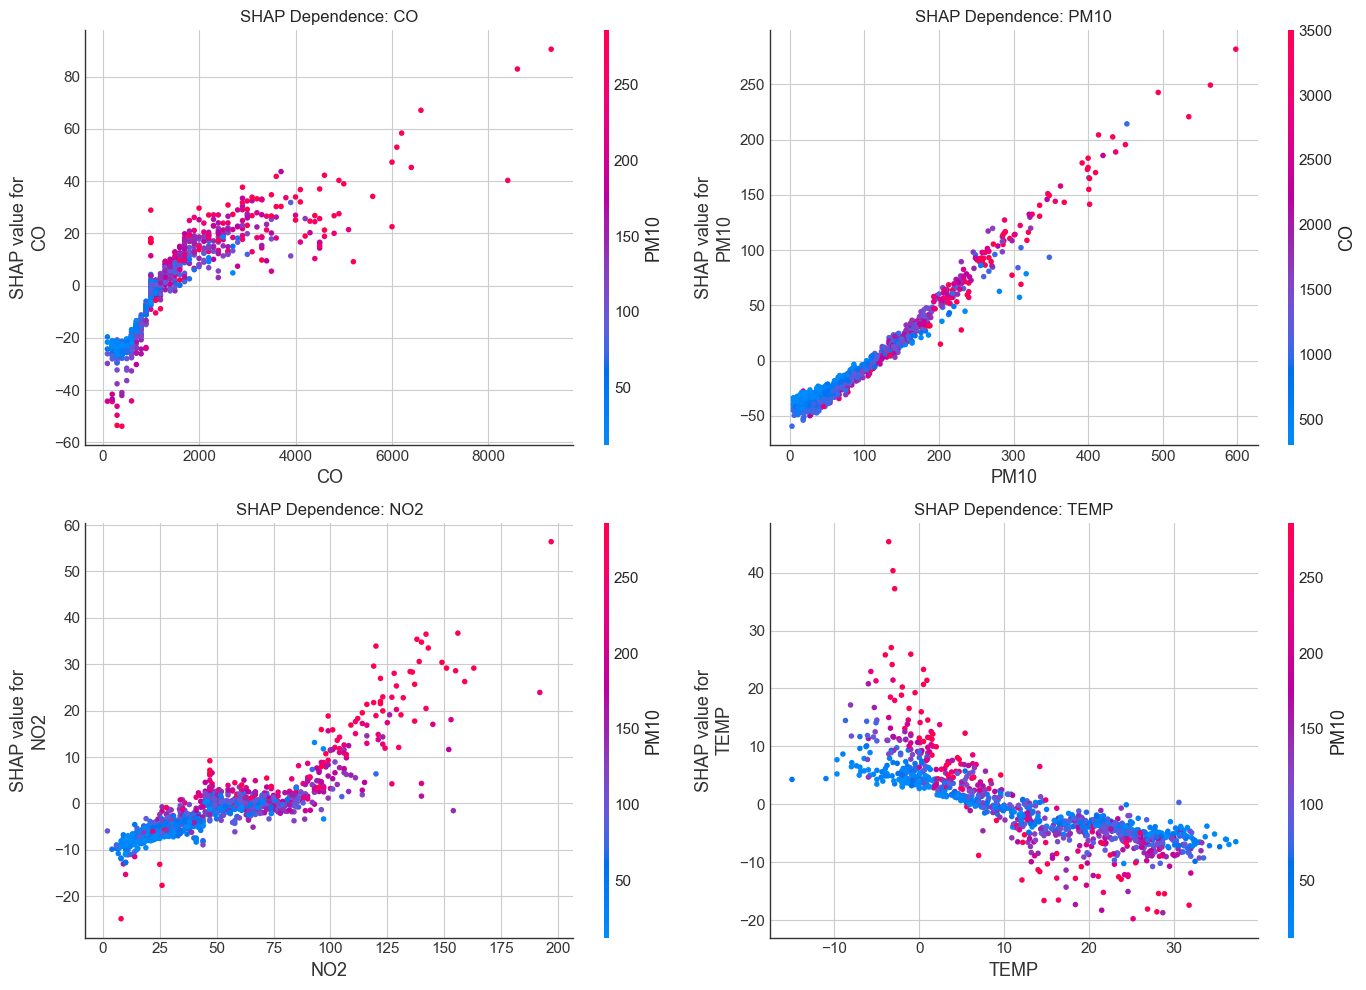

In [43]:
# Dependence plots for top features
top_features = ['CO', 'PM10', 'NO2', 'TEMP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, feature in zip(axes.flatten(), top_features):
    shap.dependence_plot(feature, shap_values, X_sample, ax=ax, show=False)
    ax.set_title(f'SHAP Dependence: {feature}')

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_dependence_plots.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.4 SHAP Analysis for Wind Direction (wd)

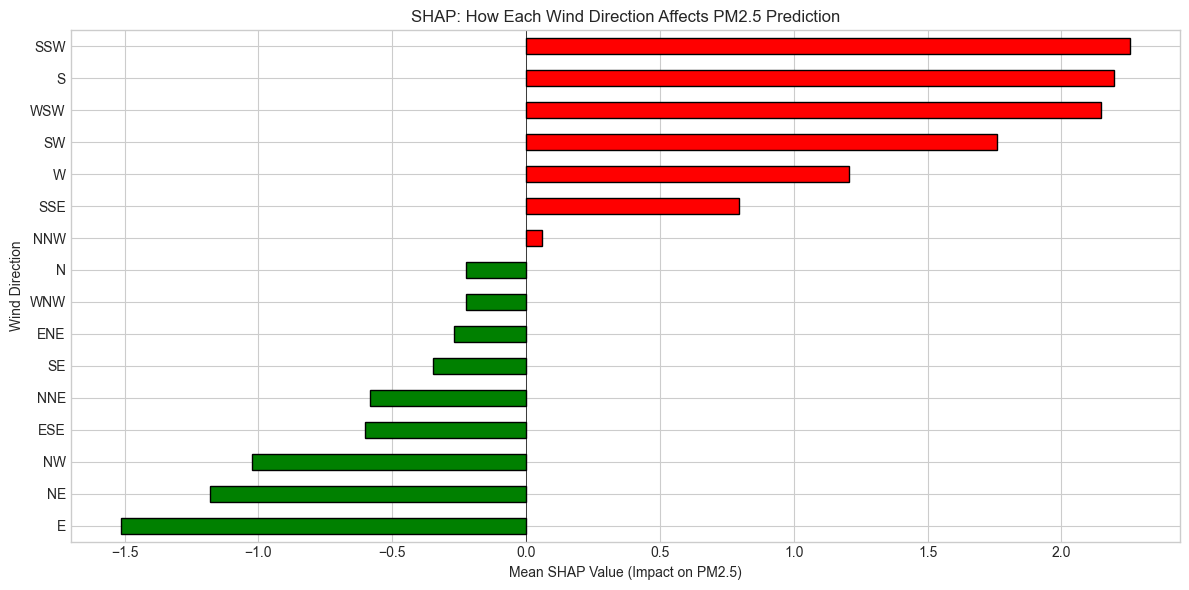


Wind Direction Impact on PM2.5:
Directions that REDUCE pollution (negative SHAP):
  E    : -1.51
  NE   : -1.18
  NW   : -1.02
  ESE  : -0.60
  NNE  : -0.58
  SE   : -0.35
  ENE  : -0.27
  WNW  : -0.23
  N    : -0.23

Directions that INCREASE pollution (positive SHAP):
  NNW  : +0.06
  SSE  : +0.79
  W    : +1.21
  SW   : +1.76
  WSW  : +2.15
  S    : +2.19
  SSW  : +2.25


In [44]:
# SHAP values by wind direction
# Get the index of 'wd' feature
wd_idx = FEATURES.index('wd')
wd_shap = shap_values[:, wd_idx]

# Create DataFrame with wind direction and SHAP values
wd_shap_df = pd.DataFrame({
    'wd': X_sample['wd'].values,
    'SHAP': wd_shap
})

# Calculate mean SHAP value for each wind direction
wd_mean_shap = wd_shap_df.groupby('wd')['SHAP'].mean().sort_values()

# Plot
plt.figure(figsize=(12, 6))
colors = ['green' if x < 0 else 'red' for x in wd_mean_shap.values]
wd_mean_shap.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Mean SHAP Value (Impact on PM2.5)')
plt.ylabel('Wind Direction')
plt.title('SHAP: How Each Wind Direction Affects PM2.5 Prediction')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/shap_wind_direction.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nWind Direction Impact on PM2.5:')
print('='*50)
print('Directions that REDUCE pollution (negative SHAP):')
for wd, val in wd_mean_shap[wd_mean_shap < 0].items():
    print(f'  {wd:5}: {val:+.2f}')
print('\nDirections that INCREASE pollution (positive SHAP):')
for wd, val in wd_mean_shap[wd_mean_shap >= 0].items():
    print(f'  {wd:5}: {val:+.2f}')

### 7.5 SHAP Summary

In [45]:
# SHAP analysis summary
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Mean |SHAP|': mean_shap
}).sort_values('Mean |SHAP|', ascending=False)

print("\n" + "="*60)
print("SHAP FEATURE IMPORTANCE SUMMARY")
print("="*60)
print(shap_importance.to_string(index=False))
print("="*60)


SHAP FEATURE IMPORTANCE SUMMARY
Feature  Mean |SHAP|
   PM10    35.665028
     CO    15.565733
   DEWP    13.012481
    SO2     5.857065
   TEMP     5.505015
  month     5.300391
    NO2     4.948030
     O3     4.381409
   PRES     2.314697
   hour     2.170019
     wd     1.383501
   WSPM     0.953452
   RAIN     0.184699


---
## 8. DiCE Counterfactual Explanation

**Method**: DiCE (Diverse Counterfactual Explanations)  
**Type**: Model-agnostic, Post-hoc, Local  
**Question answered**: "What minimal changes would result in a different outcome?"

In [46]:
# Prepare data for DiCE
# DiCE requires a DataFrame with both features and target

# Create a sample dataset for DiCE
dice_data = X_train.copy()
dice_data[TARGET] = y_train

# Convert categorical to string for DiCE
dice_data['wd'] = dice_data['wd'].astype(str)

print(f"DiCE data shape: {dice_data.shape}")

DiCE data shape: (24032, 14)


In [47]:
# Define feature types for DiCE
continuous_features = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
categorical_features = ['wd', 'hour', 'month']

# Create DiCE data object
d = dice_ml.Data(
    dataframe=dice_data,
    continuous_features=continuous_features,
    outcome_name=TARGET
)

print("DiCE Data object created")

DiCE Data object created


In [48]:
# Create a wrapper model for DiCE
# DiCE converts columns to 'object' type, but XGBoost needs proper types

class ModelWrapper:
    def __init__(self, model, cat_feature='wd', cat_categories=None, continuous_features=None):
        self.model = model
        self.cat_feature = cat_feature
        self.cat_categories = cat_categories
        self.continuous_features = continuous_features or []
    
    def predict(self, X):
        X_copy = X.copy()
        
        # Convert continuous features to float (DiCE may convert them to object)
        for col in self.continuous_features:
            if col in X_copy.columns:
                X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        
        # Convert integer features
        for col in ['hour', 'month']:
            if col in X_copy.columns:
                X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce').astype(int)
        
        # Convert categorical feature
        if self.cat_feature in X_copy.columns:
            X_copy[self.cat_feature] = pd.Categorical(
                X_copy[self.cat_feature], 
                categories=self.cat_categories
            )
        
        return self.model.predict(X_copy)

# Get categories from training data
wd_categories = X_train['wd'].cat.categories.tolist()
wrapped_model = ModelWrapper(model, 'wd', wd_categories, continuous_features)

# Create DiCE model object
m = dice_ml.Model(model=wrapped_model, backend='sklearn', model_type='regressor')

print("DiCE Model object created")

DiCE Model object created


In [49]:
# Create DiCE explainer
exp = dice_ml.Dice(d, m, method='random')

print("DiCE Explainer created")

DiCE Explainer created


In [50]:
# Select a high pollution instance to explain
# Find a sample with high PM2.5 (above 90th percentile)
high_pollution_mask = y_test > y_test.quantile(0.9)
high_pollution_samples = X_test[high_pollution_mask].head(1)

# Convert to format DiCE expects
query_instance = high_pollution_samples.copy()
query_instance['wd'] = query_instance['wd'].astype(str)

print("Query instance (High Pollution):")
print(query_instance)
print(f"\nActual PM2.5: {y_test[high_pollution_samples.index[0]]:.2f}")
print(f"Predicted PM2.5: {model.predict(high_pollution_samples)[0]:.2f}")

Query instance (High Pollution):
        PM10   SO2   NO2      CO   O3  TEMP    PRES  DEWP  RAIN  WSPM   wd  \
20412  228.0  10.0  92.0  1000.0  2.0  25.9  1000.0  21.3   0.0   2.7  ENE   

       hour  month  
20412    12      6  

Actual PM2.5: 226.00
Predicted PM2.5: 162.88


In [51]:
# Generate counterfactuals
# Target: reduce PM2.5 to below 50 (Good air quality)

print("Generating counterfactual explanations...")
print("Goal: Reduce PM2.5 from high (>100) to good (<50)")

cf = exp.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=[0, 50],  # Target PM2.5 range
    features_to_vary=continuous_features + ['wd'],  # Allow these features to change
    permitted_range={
        'CO': [0, 5000],
        'NO2': [0, 200],
        'WSPM': [0, 20],
        'TEMP': [-20, 40]
    },
    random_seed=0  # Fixed seed for reproducibility
)

print("\nCounterfactuals generated!")

Generating counterfactual explanations...
Goal: Reduce PM2.5 from high (>100) to good (<50)


100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


Counterfactuals generated!


In [52]:
# Display counterfactuals
cf.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 163.0)


,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd,hour,month,PM2.5
0,228.0,10.0,92.0,1000.0,2.0,25.9,1000.0,21.299999,0.0,2.7,ENE,12,6,163.0



Diverse Counterfactual set (new outcome: [0, 50])


,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd,hour,month,PM2.5
0,128.3,-,-,-,-,-,-,-26.5,-,-,-,-,-,41.37956619262695
1,33.7,-,6.7,-,-,-,-,-,-,-,-,-,-,43.50096893310547
2,3.3,-,-,-,-,-,-,-,0.1,-,-,-,-,28.897205352783203


In [53]:
# Save counterfactuals to CSV
cf_df = cf.cf_examples_list[0].final_cfs_df
cf_df.to_csv('../outputs/tables/counterfactuals.csv', index=False)
print("Counterfactuals saved to outputs/tables/counterfactuals.csv")

Counterfactuals saved to outputs/tables/counterfactuals.csv


### 8.1 DiCE Counterfactual Visualization

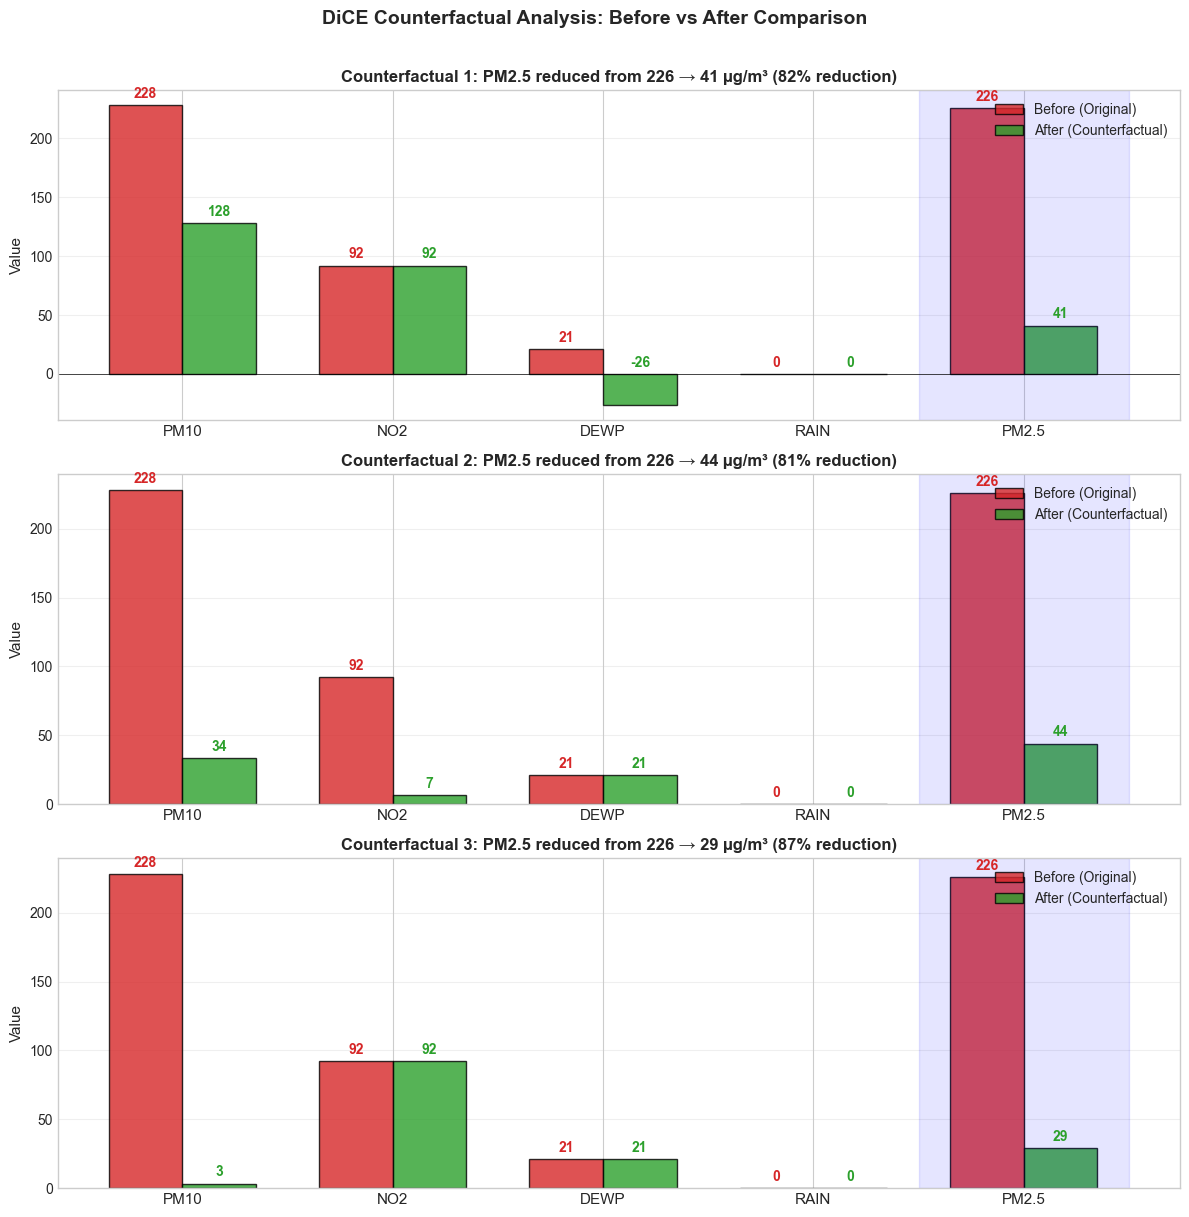


BEFORE/AFTER COMPARISON SUMMARY

CF 1: PM2.5 226 → 41 µg/m³ (82% ↓)
    PM10: 228.0 → 128.3 (-44%)
    DEWP: 21.3 → -26.5 (-224%)

CF 2: PM2.5 226 → 44 µg/m³ (81% ↓)
    PM10: 228.0 → 33.7 (-85%)
    NO2: 92.0 → 6.7 (-93%)

CF 3: PM2.5 226 → 29 µg/m³ (87% ↓)
    PM10: 228.0 → 3.3 (-99%)
    RAIN: 0.0 → 0.1 (+0%)


In [54]:
# Visualize Counterfactual Scenarios - Before/After Comparison
# Shows the direct relationship: Change features → PM2.5 drops

# Get original values
original = query_instance.iloc[0]
original_pm25 = y_test[high_pollution_samples.index[0]]

# Identify features that changed across ANY counterfactual
changed_features = []
for col in FEATURES:
    for i, cf_row in cf_df.iterrows():
        if col in cf_row.index and col in original.index:
            try:
                if abs(float(original[col]) - float(cf_row[col])) > 0.01:
                    if col not in changed_features:
                        changed_features.append(col)
                    break
            except (ValueError, TypeError):
                if original[col] != cf_row[col]:
                    if col not in changed_features:
                        changed_features.append(col)
                    break

# Add PM2.5 as the outcome
all_features = changed_features + ['PM2.5']

# Create figure - one row per counterfactual
n_cfs = len(cf_df)
fig, axes = plt.subplots(n_cfs, 1, figsize=(12, 4*n_cfs))
if n_cfs == 1:
    axes = [axes]

for cf_idx, (idx, cf_row) in enumerate(cf_df.iterrows()):
    ax = axes[cf_idx]
    
    # Get values for this counterfactual
    orig_vals = [float(original[f]) for f in changed_features] + [original_pm25]
    cf_vals = [float(cf_row[f]) if f in cf_row.index else float(original[f]) for f in changed_features] + [cf_row[TARGET]]
    
    x = np.arange(len(all_features))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, orig_vals, width, label='Before (Original)', 
                   color='#d62728', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, cf_vals, width, label='After (Counterfactual)', 
                   color='#2ca02c', alpha=0.8, edgecolor='black')
    
    # Add value labels
    for bar, val in zip(bars1, orig_vals):
        height = bar.get_height()
        ax.annotate(f'{val:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, max(height, 0)),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='#d62728')
    
    for bar, val in zip(bars2, cf_vals):
        height = bar.get_height()
        ax.annotate(f'{val:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, max(height, 0)),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='#2ca02c')
    
    # Add arrows showing reduction for PM2.5
    pm25_reduction = original_pm25 - cf_row[TARGET]
    pm25_pct = (pm25_reduction / original_pm25) * 100
    
    ax.set_ylabel('Value', fontsize=11)
    ax.set_title(f'Counterfactual {cf_idx+1}: PM2.5 reduced from {original_pm25:.0f} → {cf_row[TARGET]:.0f} µg/m³ ({pm25_pct:.0f}% reduction)', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(all_features, fontsize=11)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0, color='black', linewidth=0.5)
    
    # Highlight PM2.5 column with background
    ax.axvspan(len(changed_features) - 0.5, len(changed_features) + 0.5, alpha=0.1, color='blue')

plt.suptitle('DiCE Counterfactual Analysis: Before vs After Comparison', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../outputs/figures/01_shap_dice_analysis/dice_counterfactual_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('BEFORE/AFTER COMPARISON SUMMARY')
print('='*60)
for cf_idx, (idx, cf_row) in enumerate(cf_df.iterrows()):
    pm25_reduction = original_pm25 - cf_row[TARGET]
    pm25_pct = (pm25_reduction / original_pm25) * 100
    print(f'\nCF {cf_idx+1}: PM2.5 {original_pm25:.0f} → {cf_row[TARGET]:.0f} µg/m³ ({pm25_pct:.0f}% ↓)')
    for f in changed_features:
        orig = float(original[f])
        new = float(cf_row[f])
        if abs(orig - new) > 0.01:
            pct = ((new - orig) / abs(orig)) * 100 if orig != 0 else 0
            print(f'    {f}: {orig:.1f} → {new:.1f} ({pct:+.0f}%)')
print('='*60)

In [55]:
# Interpret counterfactuals
print("\n" + "="*60)
print("COUNTERFACTUAL INTERPRETATION")
print("="*60)
print("\nOriginal Instance (High Pollution):")
print(f"  PM2.5: {y_test[high_pollution_samples.index[0]]:.1f} µg/m³ (Unhealthy)")
print("\nTo achieve Good Air Quality (PM2.5 < 50), the model suggests:")
print("-" * 60)

original = query_instance.iloc[0]
for i, cf_row in cf_df.iterrows():
    print(f"\nCounterfactual {i+1}:")
    for col in FEATURES:
        if col in cf_row.index:
            orig_val = original[col]
            cf_val = cf_row[col]
            if orig_val != cf_val:
                print(f"  {col}: {orig_val} → {cf_val}")
    print(f"  Resulting PM2.5: {cf_row[TARGET]:.1f} µg/m³")

print("="*60)


COUNTERFACTUAL INTERPRETATION

Original Instance (High Pollution):
  PM2.5: 226.0 µg/m³ (Unhealthy)

To achieve Good Air Quality (PM2.5 < 50), the model suggests:
------------------------------------------------------------

Counterfactual 1:
  PM10: 228.0 → 128.3
  DEWP: 21.3 → -26.5
  Resulting PM2.5: 41.0 µg/m³

Counterfactual 2:
  PM10: 228.0 → 33.7
  NO2: 92.0 → 6.7
  Resulting PM2.5: 44.0 µg/m³

Counterfactual 3:
  PM10: 228.0 → 3.3
  RAIN: 0.0 → 0.1
  Resulting PM2.5: 29.0 µg/m³


---
## 9. Summary & Conclusions

In [56]:
print("="*70)
print("XAI AIR QUALITY ANALYSIS - SUMMARY")
print("="*70)

print("\n📊 DATASET")
print("-"*70)
print(f"  Source: Beijing Dongsi Station (Urban Center)")
print(f"  Period: March 2013 - February 2017")
print(f"  Samples: {len(X):,} hourly observations")
print(f"  Features: {len(FEATURES)} (5 pollutants + 5 weather + 1 wind + 2 temporal)")
print(f"  Target: PM2.5 (Fine Particulate Matter)")

print("\n🤖 MODEL PERFORMANCE")
print("-"*70)
print(f"  Model: XGBoost Regressor")
print(f"  Test RMSE: {test_metrics['RMSE']:.4f}")
print(f"  Test MAE: {test_metrics['MAE']:.4f}")
print(f"  Test R²: {test_metrics['R2']:.4f}")

print("\n🔍 SHAP INSIGHTS (Feature Importance)")
print("-"*70)
print("  Top 5 Important Features:")
for i, row in shap_importance.head(5).iterrows():
    print(f"    {i+1}. {row['Feature']}: {row['Mean |SHAP|']:.4f}")

print("\n🔄 COUNTERFACTUAL INSIGHTS (DiCE)")
print("-"*70)
print("  To reduce PM2.5 from Unhealthy to Good:")
print("    - Reduce CO emissions (traffic, industry)")
print("    - Increase wind speed (natural dispersion)")
print("    - Wind direction change (NW clears pollution)")

print("\n📁 OUTPUTS GENERATED")
print("-"*70)
print("  Figures:")
print("    - outputs/figures/pm25_distribution.png")
print("    - outputs/figures/correlation_matrix.png")
print("    - outputs/figures/shap_summary_bar.png")
print("    - outputs/figures/shap_summary_beeswarm.png")
print("    - outputs/figures/shap_waterfall.png")
print("    - outputs/figures/shap_dependence_plots.png")
print("  Tables:")
print("    - outputs/tables/counterfactuals.csv")
print("  Model:")
print("    - models/xgboost_model.pkl")

print("\n" + "="*70)
print("Analysis Complete!")
print("="*70)

XAI AIR QUALITY ANALYSIS - SUMMARY

📊 DATASET
----------------------------------------------------------------------
  Source: Beijing Dongsi Station (Urban Center)
  Period: March 2013 - February 2017
  Samples: 34,314 hourly observations
  Features: 13 (5 pollutants + 5 weather + 1 wind + 2 temporal)
  Target: PM2.5 (Fine Particulate Matter)

🤖 MODEL PERFORMANCE
----------------------------------------------------------------------
  Model: XGBoost Regressor
  Test RMSE: 18.9867
  Test MAE: 12.4257
  Test R²: 0.9501

🔍 SHAP INSIGHTS (Feature Importance)
----------------------------------------------------------------------
  Top 5 Important Features:
    1. PM10: 35.6650
    4. CO: 15.5657
    8. DEWP: 13.0125
    2. SO2: 5.8571
    6. TEMP: 5.5050

🔄 COUNTERFACTUAL INSIGHTS (DiCE)
----------------------------------------------------------------------
  To reduce PM2.5 from Unhealthy to Good:
    - Reduce CO emissions (traffic, industry)
    - Increase wind speed (natural dispersion)